# Handwritten Digit Recognition using Bipolar Sigmoid & Backpropagation


In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist

# 1. Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test  = x_test.reshape(x_test.shape[0], -1) / 255.0

def bipolar_encode(labels, num_classes=10):
    encoded = -1 * np.ones((labels.size, num_classes))
    for i, lbl in enumerate(labels):
        encoded[i, lbl] = 1
    return encoded

y_train_enc = bipolar_encode(y_train, 10)
y_test_enc  = bipolar_encode(y_test, 10)


# 2. Activation functions
def bipolar_sigmoid(x):
    return (1 - np.exp(-x)) / (1 + np.exp(-x))

def bipolar_sigmoid_derivative(x):
    f = bipolar_sigmoid(x)
    return 0.5 * (1 - f**2)

# 3. Initialize network
input_size = 784
hidden_size = 64
output_size = 10


W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1.0/input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1.0/hidden_size)
b2 = np.zeros((1, output_size))

epochs = 10
lr = 0.1
batch_size = 100

for epoch in range(epochs):
    idx = np.random.permutation(x_train.shape[0])
    x_train, y_train_enc = x_train[idx], y_train_enc[idx]

    for i in range(0, x_train.shape[0], batch_size):
        X_batch = x_train[i:i+batch_size]
        Y_batch = y_train_enc[i:i+batch_size]

        Z1 = X_batch.dot(W1) + b1
        A1 = bipolar_sigmoid(Z1)
        Z2 = A1.dot(W2) + b2
        A2 = bipolar_sigmoid(Z2)

        error = Y_batch - A2
        dZ2 = error * bipolar_sigmoid_derivative(Z2)
        dW2 = A1.T.dot(dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2.dot(W2.T)
        dZ1 = dA1 * bipolar_sigmoid_derivative(Z1)
        dW1 = X_batch.T.dot(dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Update weights
        W2 += lr * dW2 / batch_size
        b2 += lr * db2 / batch_size
        W1 += lr * dW1 / batch_size
        b1 += lr * db1 / batch_size

    # Evaluate accuracy after each epoch
    Z1 = x_test.dot(W1) + b1
    A1 = bipolar_sigmoid(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = bipolar_sigmoid(Z2)

    predictions = np.argmax(A2, axis=1)
    accuracy = np.mean(predictions == y_test)
    print(f"Epoch {epoch+1}/{epochs} - Test Accuracy: {accuracy:.4f}")


Epoch 1/10 - Test Accuracy: 0.8909
Epoch 2/10 - Test Accuracy: 0.9056
Epoch 3/10 - Test Accuracy: 0.9136
Epoch 4/10 - Test Accuracy: 0.9198
Epoch 5/10 - Test Accuracy: 0.9237
Epoch 6/10 - Test Accuracy: 0.9278
Epoch 7/10 - Test Accuracy: 0.9304
Epoch 8/10 - Test Accuracy: 0.9332
Epoch 9/10 - Test Accuracy: 0.9355
Epoch 10/10 - Test Accuracy: 0.9387


True Digit: 7
Predicted Digit: 7


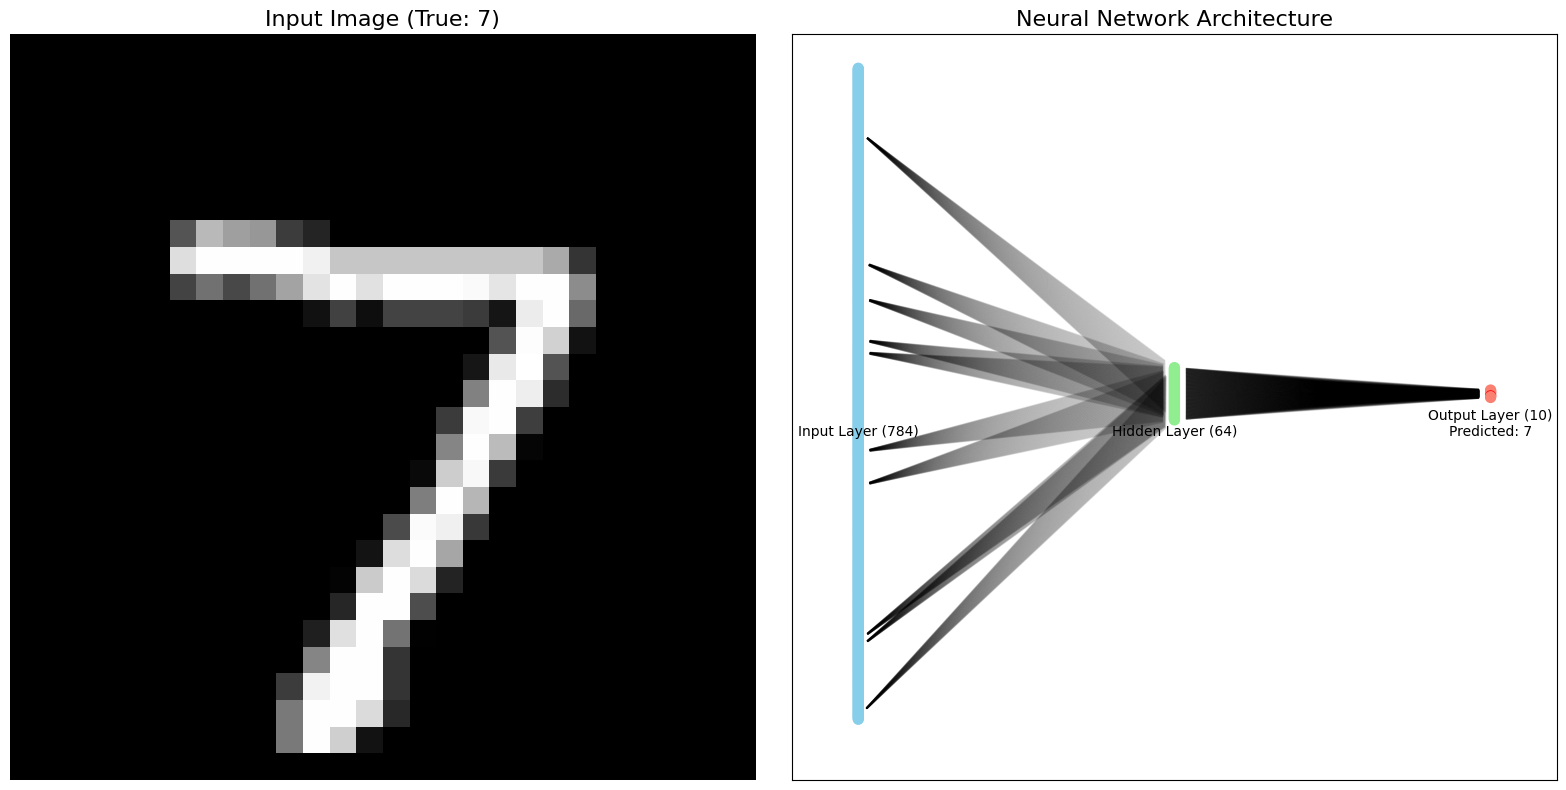

In [2]:
import matplotlib.pyplot as plt
import networkx as nx


image_index = 0
single_image = x_test[image_index:image_index+1]
true_label = y_test[image_index]

# Forward pass for the single image
Z1 = single_image.dot(W1) + b1
A1 = bipolar_sigmoid(Z1)
Z2 = A1.dot(W2) + b2
A2 = bipolar_sigmoid(Z2)

# Get the prediction
predicted_label = np.argmax(A2, axis=1)[0]

print(f"True Digit: {true_label}")
print(f"Predicted Digit: {predicted_label}")


# Create a directed graph
G = nx.DiGraph()

# Node positions for visualization
pos = {}
layer_sizes = [input_size, hidden_size, output_size]
layer_spacing = 10
node_spacing = 0.1

# Add nodes and define their positions
for i, layer_size in enumerate(layer_sizes):
    for j in range(layer_size):
        # Create a unique name for each node
        node_name = f'L{i}_{j}'
        G.add_node(node_name)
        pos[node_name] = (i * layer_spacing, (layer_size/2 - j) * node_spacing)

# Add edges between layers (fully connected)
def add_edges_subset(layer1_idx, layer2_idx, subset_size=5):
    nodes1 = [f'L{layer1_idx}_{j}' for j in range(layer_sizes[layer1_idx])]
    nodes2 = [f'L{layer2_idx}_{j}' for j in range(layer_sizes[layer2_idx])]
    for n1 in np.random.choice(nodes1, subset_size, replace=False):
        for n2 in nodes2:
            G.add_edge(n1, n2)

# Edges from a subset of Input -> Hidden
add_edges_subset(0, 1, subset_size=10)
# Edges from Hidden -> Output
for h_node in range(layer_sizes[1]):
    for o_node in range(layer_sizes[2]):
        G.add_edge(f'L1_{h_node}', f'L2_{o_node}')


fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. Plot the input image
axes[0].imshow(single_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f'Input Image (True: {true_label})', fontsize=16)
axes[0].axis('off')

# 2. Plot the network diagram
ax = axes[1]
node_colors = []
for node in G.nodes():
    layer = int(node.split('_')[0][1:])
    index = int(node.split('_')[1])
    if layer == 0:  # Input layer
        node_colors.append('skyblue')
    elif layer == 1:  # Hidden layer
        node_colors.append('lightgreen')
    else:  # Output layer
        if index == predicted_label:
            node_colors.append('red')
        else:
            node_colors.append('salmon')

nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.1, arrowstyle='-', ax=ax)

ax.set_title('Neural Network Architecture', fontsize=16)
ax.text(0, -5, 'Input Layer (784)', ha='center')
ax.text(10, -5, 'Hidden Layer (64)', ha='center')
ax.text(20, -5, f'Output Layer (10)\nPredicted: {predicted_label}', ha='center')

plt.tight_layout()
plt.show()